In [1]:
import os
import seaborn as sns
import pandas as pd
from google.colab import drive
import numpy as np
from osgeo import gdal
from matplotlib import pyplot as plt

from __future__ import division
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install -q xlrd

**Read Dataset into ds variable, then read this by numpy 2d array**

In [4]:
path_ = "/content/drive/MyDrive/Knowledge/Data_Science_Prj/vnm_pd_2019_1km_UNadj.tif"

In [6]:
ds = gdal.Open(path_)
ds_band = ds.GetRasterBand(1)
nodataval = ds_band.GetNoDataValue()
ds_arr = ds.ReadAsArray().astype(np.float64)
print(ds_arr)
print(ds_arr.shape)

[[-99999. -99999. -99999. ... -99999. -99999. -99999.]
 [-99999. -99999. -99999. ... -99999. -99999. -99999.]
 [-99999. -99999. -99999. ... -99999. -99999. -99999.]
 ...
 [-99999. -99999. -99999. ... -99999. -99999. -99999.]
 [-99999. -99999. -99999. ... -99999. -99999. -99999.]
 [-99999. -99999. -99999. ... -99999. -99999. -99999.]]
(1781, 879)


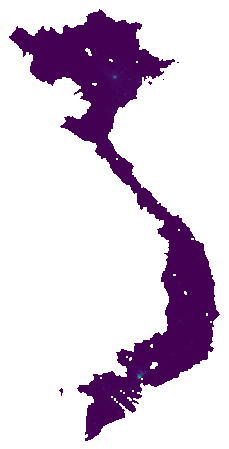

In [ ]:
# replace missing values if necessary
if np.any(ds_arr == nodataval):
    ds_arr[ds_arr == nodataval] = np.nan

#View the data we're using
plt.figure(figsize = (8, 8))
plt.axis("off")
img = plt.imshow(ds_arr, cmap = "viridis")

In [ ]:
df=pd.read_excel('/content/drive/My Drive/Knowledge/Data_Science_Prj/EPA_merged_2019.xlsx')

In [ ]:
point_set = df.drop_duplicates(subset=['Lat', 'Lon'])
point_set = point_set.loc[:,['Lat', 'Lon']]
lat_lon = point_set.to_numpy()

In [ ]:
prj = ds.GetProjection()
gt = ds.GetGeoTransform()
print(prj)
print(gt)

GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]
(102.14874960275003, 0.0083333333, 0.0, 23.399583438627147, 0.0, -0.0083333333)


In [ ]:
from osgeo import ogr
from osgeo import osr
proj = osr.SpatialReference(wkt=prj)
print(proj.GetAttrValue('AUTHORITY',1))

4326


In [ ]:
def get_coords_at_point(gt, pos):
    row = int((pos[1] - gt[0])/gt[1])
    col = int((pos[0] - gt[3])/gt[5])
    return col, row

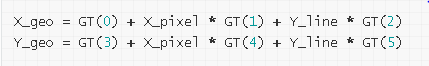

In [ ]:
point_coor = []
for p in lat_lon:
    col, row = get_coords_at_point(gt, p)
    point_coor.append([col, row])

print(point_coor)

[[284, 444], [283, 443], [287, 442], [281, 430], [284, 434], [281, 435], [285, 439], [286, 438], [289, 444], [287, 431]]


In [ ]:
DEGREE_TO_KILOMETER = 111
R = 5
# radius = 5 kilometer
R_degree = R/111
R_cell = R_degree/gt[1]
print(R_degree, R_cell)
# circle = (row, col, R_cell)

0.04504504504504504 5.405405427027026


In [ ]:
def int_ceiling(x):
        return int(np.ceil(x))

def points_in_circle(circle, arr):
    buffer_points = []
    i0, j0, r = circle
    for i in range(int_ceiling(i0 - r), int_ceiling(i0 + r)):
        # ri = np.sqrt(r**2 - (i - i0)**2)
        for j in range(int_ceiling(j0 - r), int_ceiling(j0 + r)):
            buffer_points.append(arr[i][j])
            # arr[i][j] = np.nan
    
    return buffer_points

"""
uniques = np.unique(buffer_points)
counts = np.zeros(len(uniques))
for x in uniques:
    counts[x] = (np.count(buffer_points, x))
"""

buffers_points = []
for pc in point_coor:
    circle = (pc[0], pc[1], R_cell)
    buffers_points.append(points_in_circle(circle, ds_arr))

"""
fig = plt.figure(figsize = (20, 20))
ax = fig.add_subplot(111)
plt.axis("off")
img = plt.imshow(ds_arr, cmap = "viridis")
"""
print(buffers_points)

[[12729.5048828125, 5930.912109375, 10482.0400390625, 3583.89404296875, 1101.346435546875, 1974.951171875, 2120.906494140625, 2770.289794921875, 5288.271484375, 8251.2470703125, 4558.76806640625, 5591.7958984375, 4553.97265625, 12627.638671875, 12442.27734375, 2289.204833984375, 740.4324951171875, 3274.336181640625, 4474.24853515625, 5968.23486328125, 9257.8818359375, 13275.6279296875, 9148.376953125, 1399.8797607421875, 1262.8402099609375, 12157.169921875, 7227.36474609375, 1353.411376953125, 3129.3916015625, 4768.1123046875, 6362.1240234375, 9569.0478515625, 6469.52490234375, 26478.58203125, 7525.6552734375, 2345.5791015625, 8615.0517578125, 24882.390625, 6685.505859375, 2754.482177734375, 13890.255859375, 15035.7509765625, 5853.82421875, 5056.81982421875, 43168.56640625, 41280.25, 24684.08984375, 19094.822265625, 43223.25, 26132.365234375, 5375.4423828125, 9045.4716796875, 7022.25634765625, 4358.642578125, 5297.16650390625, 31055.556640625, 34490.453125, 51600.640625, 49462.3828125,

In [ ]:
mean_each_buff = []
for bp in buffers_points:
    mean_each_buff.append(np.mean(bp))

for m in mean_each_buff: print(m)

19172.362838871224
19595.2660058392
23216.10414161367
5047.75194404539
12171.718667274665
11232.507669748353
22568.947371553782
21253.185205885202
18068.852536540388
7021.126028013623
